# Question 4

This script compares a high pass Kaiser-windowed FIR filter designed using the windowing method with an optimal filter designed using the Parks-McClellan method (Remez exchange algorithm).

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from a2_config import A2_ROOT, SAVEFIG_CONFIG

In [2]:
# Define filter specifications

F_SAMP  = 50    # sampling frequency, kHz
F_STOP  = 10    # stop band end, kHz
F_PASS  = 12    # pass band start, kHz
A_STOP  = 80    # stop band attenuation, dB
A_PASS  = 3     # pass band attenuation, dB

### Windowing Method

In [3]:
ripple_p = 1 - np.power(10, -A_PASS / 20)
ripple_s = np.power(10, -A_STOP / 20)
print("Maximum pass band ripple:", ripple_p)
print("Maximum stop band ripple:", ripple_s)

A = -20 * np.log10(min(ripple_p, ripple_s))
print("Required attenuation:", A, "dB")

Maximum pass band ripple: 0.2920542156158621
Maximum stop band ripple: 0.0001
Required attenuation: 80.0 dB


In [4]:
# Kaiser window filter length estimate
N = int(np.ceil((A - 7.95)/(14.36 * ((F_PASS - F_STOP) / F_SAMP))))
print("Filter length estimate:", N)

beta = 0.1102 * (A - 8.7)
print("Kaiser window beta:", beta)

Filter length estimate: 126
Kaiser window beta: 7.85726


Create the frequency domain vector, $V$, which represents the ideal frequency response.

Bins in passband: 33


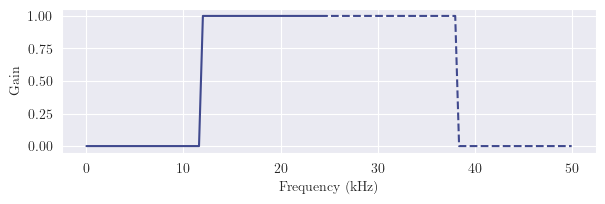

In [5]:
# Calculate pass band width, L
L = int(np.round(N * (0.5 * F_SAMP - F_PASS) / F_SAMP))
print("Bins in passband:", L)

# Construct V, with 1's in the pass band and 0's in the stop band
V = np.zeros(N//2)
V[-L:] = np.ones(L)
V = np.concatenate([V, np.flip(V)])

# Construct a frequency axis for plotting
f = np.linspace(0, F_SAMP, N)

# Plot ideal frequency response, represented by vector V
fig, ax = plt.subplots(figsize=(6, 2))
fig.tight_layout()

palette = sns.color_palette()

sns.lineplot(x=f[:N//2], y=V[:N//2], ax=ax, c=palette[0], ls="-")
sns.lineplot(x=f[N//2:], y=V[N//2:], ax=ax, c=palette[0], ls="--")

ax.set_xlabel("Frequency (kHz)")
ax.set_ylabel("Gain")

fname = Path(A2_ROOT, "output", "q4_ideal_freqz.png")
fig.savefig(fname, **SAVEFIG_CONFIG)

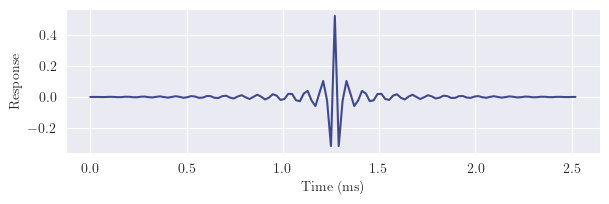

In [6]:
from scipy.fft import fft, fftshift, ifft

# Impulse (time) response of ideal filter
v = fftshift(ifft(V))

# Plot the ideal impulse response
fig, ax = plt.subplots(figsize=(6, 2))
fig.tight_layout()

t = np.linspace(0, N / F_SAMP, N)
sns.lineplot(x=t, y=v.real, ax=ax)

ax.set_xlabel("Time (ms)")
ax.set_ylabel("Response")

fname = Path(A2_ROOT, "output", "q4_ideal_impz.png")
fig.savefig(fname, **SAVEFIG_CONFIG)

In [7]:
# Helper function for converting frequency response to dB scale
dB = lambda x: 20 * np.log10(x)

def plot_freqz(w, h, fname=None, save=False):
    """Plott frequency response and overlay filter requirements."""
    fig, ax = plt.subplots(figsize=(6, 3))
    fig.tight_layout()
    sns.lineplot(x=w, y=dB(np.abs(h)), ax=ax)
    # Plot stop band requirement
    ax.axhline(-80, c="r", lw=0.5, label="Stop band requirement")
    ax.axvline( 10, c="r", lw=0.5)
    # Plot pass band requirement
    ax.axhline( -3, c="g", lw=0.5, label="Pass band requirement")
    ax.axvline( 12, c="g", lw=0.5)
    # Axis labels
    ax.set_xlabel("Frequency (kHz)")
    ax.set_ylabel("Gain (dB)")
    ax.legend(framealpha=1)
    # Save or just show
    if save:
        if not fname:
            raise ValueError("save is True but no file name was provided")
        fig.savefig(Path(A2_ROOT, "output", fname), **SAVEFIG_CONFIG)
    plt.show()

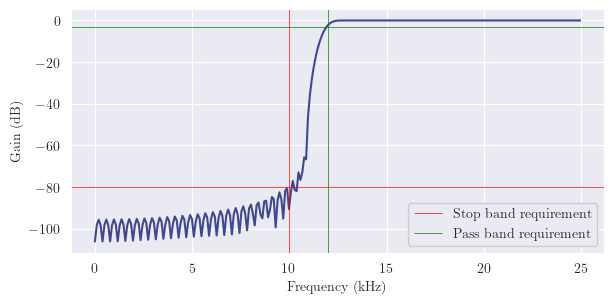

In [10]:
from scipy.signal.windows import kaiser

f = np.linspace(0, F_SAMP, 512)
V_kaiser = fft(v * kaiser(N, beta), 512)[:256]

plot_freqz(f[:256], V_kaiser[:256], fname="q4_kaiser_freqz.png", save=True)

### Parks-McClellan Method

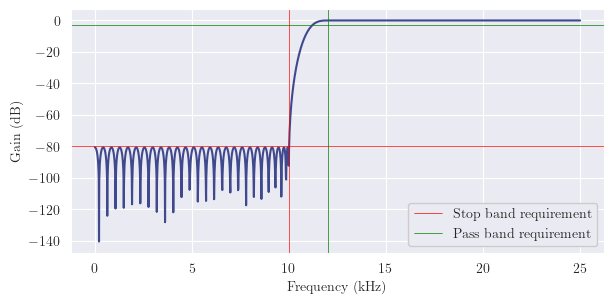

In [9]:
# Optimal filter design using Parks-McClellan method (Remez exchange algorithm)
import scipy.signal as signal

numtaps = 119
edges = [0, F_STOP, F_PASS, 0.5 * F_SAMP]
taps = signal.remez(numtaps, edges, [0, 1], fs=F_SAMP)
w, h = signal.freqz(taps, [1], worN=2000, fs=F_SAMP)
plot_freqz(w, h, fname="q4_optimal_freqz.png", save=True)